In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle

! pip install openpyxl

In [40]:
all_df = pd.read_excel('Real_estate_valuation_data_set.xlsx',index_col=False)
all_df = shuffle(all_df)
all_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
257,258,2013.250000,17.3,444.1334,1,24.97501,121.52730,43.9
202,203,2012.916667,38.3,642.6985,3,24.97559,121.53713,31.5
250,251,2013.166667,39.2,424.7132,7,24.97429,121.53917,30.0
103,104,2012.750000,0.0,208.3905,6,24.95618,121.53844,45.7
392,393,2013.083333,42.7,443.8020,6,24.97927,121.53874,35.3
...,...,...,...,...,...,...,...,...
262,263,2012.916667,15.9,289.3248,5,24.98203,121.54348,53.0
335,336,2013.583333,27.3,337.6016,6,24.96431,121.54063,36.5
219,220,2012.750000,29.3,529.7771,8,24.98102,121.53655,40.2
323,324,2013.416667,28.6,197.1338,6,24.97631,121.54436,42.5


In [41]:
all_df.info()
all_df = all_df.drop("No",axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 257 to 336
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 29.1 KB


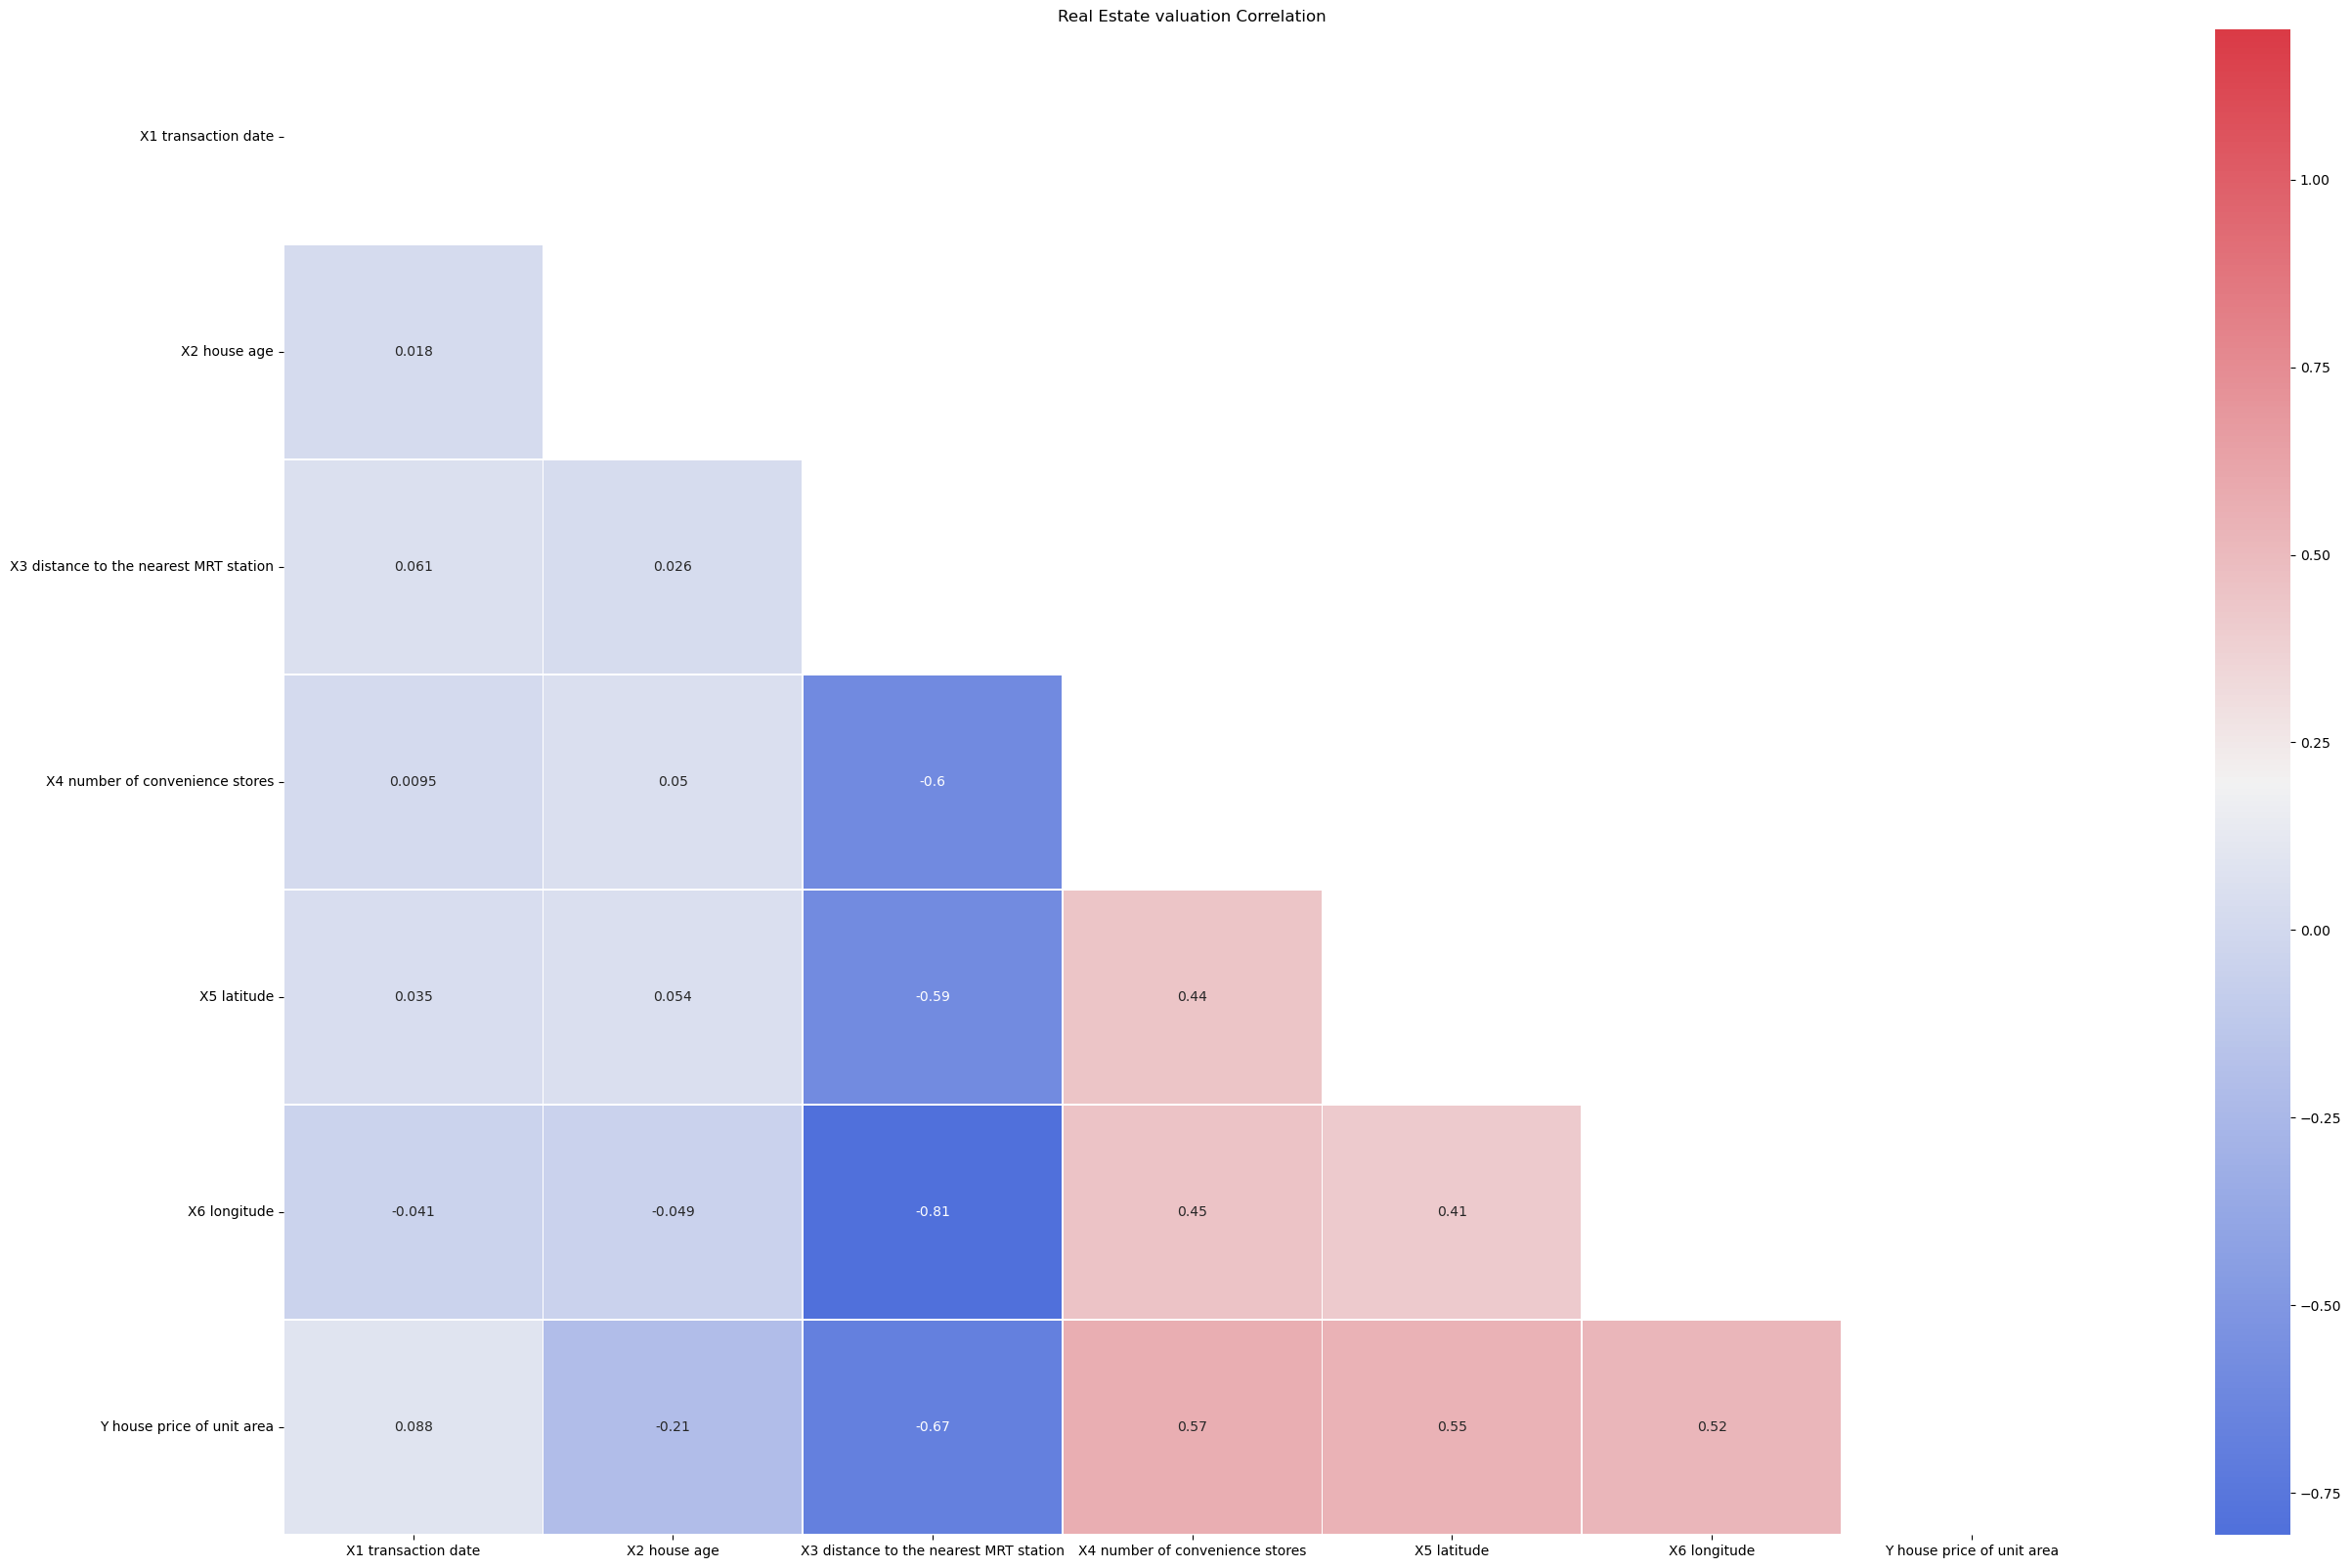

In [42]:
corrMatt = all_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

In [43]:
Xs = all_df.drop("Y house price of unit area",axis=1)
target = all_df['Y house price of unit area']

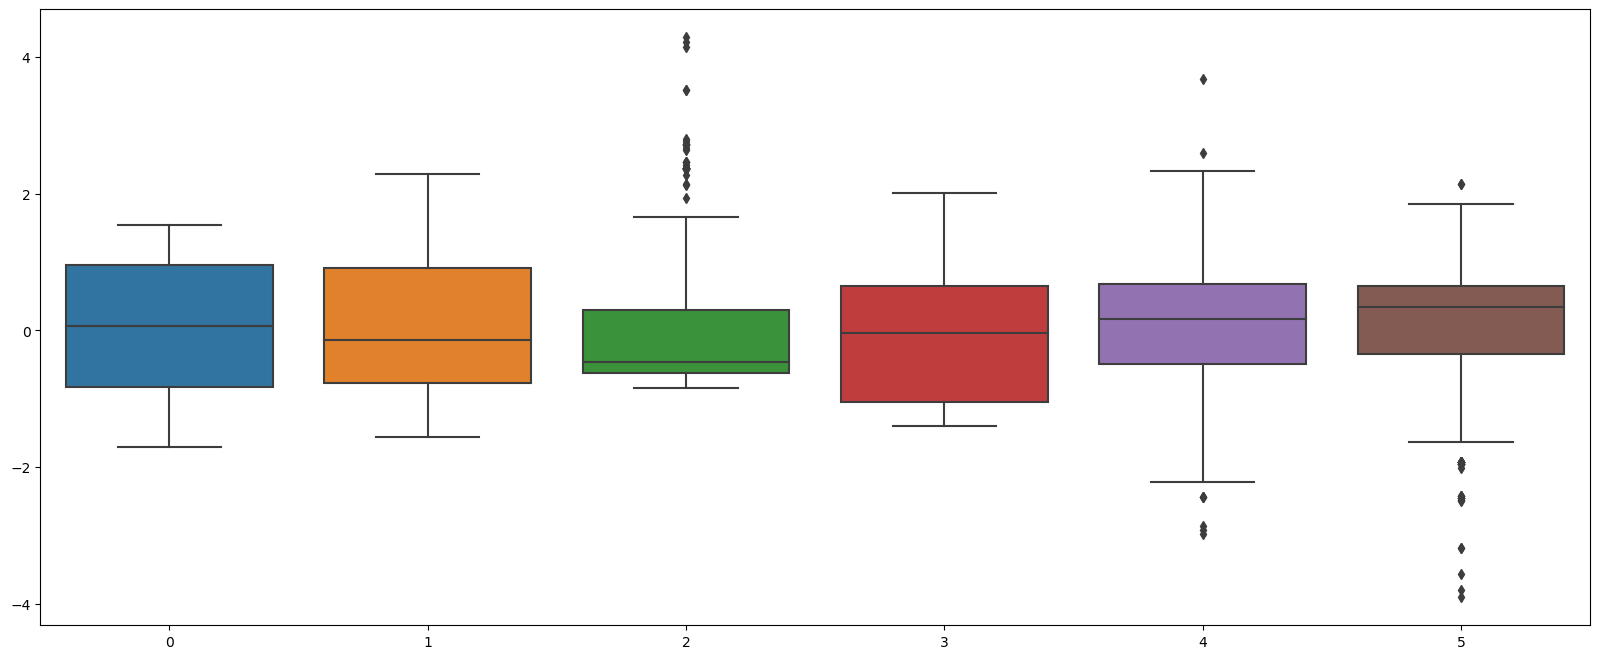

In [44]:
scaler = StandardScaler()
features = scaler.fit_transform(Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [46]:
#define currency conversion
def curr_conversion(score):
    result = np.sqrt(score)
    result = result/3.3
    result = result/37
    return result

### 2. Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
cv_error = np.average(cross_val_score(clf, features, target, scoring = 'neg_mean_squared_error')) * (-1)
print('The {}-fold cross-validation MSE score for this method is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation MSE score for this method is 81.78


In [48]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(cv_error)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.07407


### 3. SVM

In [49]:
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVR(kernel="rbf", gamma='auto')

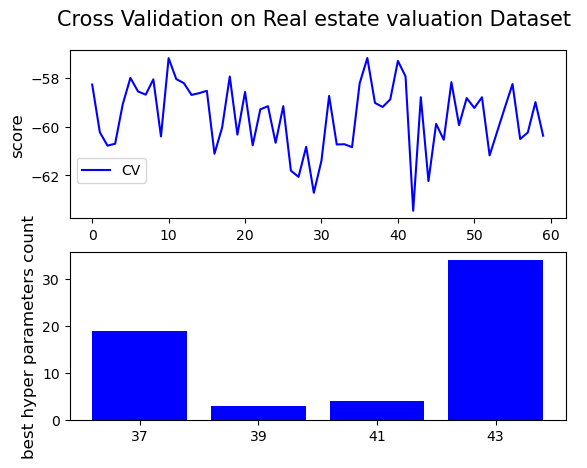

In [50]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [37,39,41,43]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error')
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-37)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Real estate valuation Dataset ",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[37,39,41,43])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

In [51]:
svm = SVR(C = 37,kernel="rbf", gamma='auto')
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_squared_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation MSE score for this method is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this method is 64.48


In [52]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.06576


### 4. Decision Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [54]:
tree_dtr = tree.DecisionTreeRegressor()

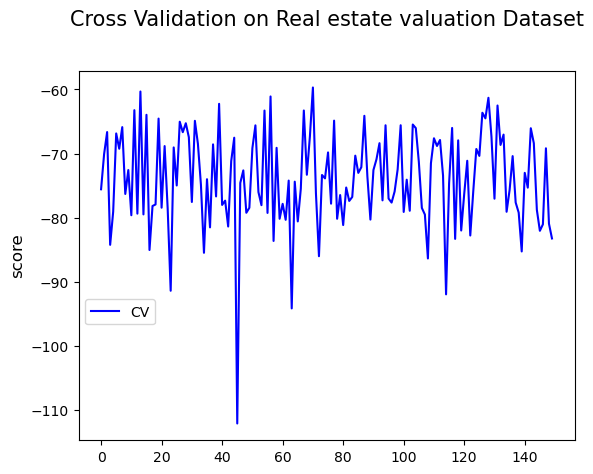

In [55]:
from sklearn.model_selection import KFold

NUM_TRIALS = 150

X = features
y = target

p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}
scores = np.zeros(NUM_TRIALS)
params = []
for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    dtr = GridSearchCV(estimator=tree_dtr, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error')
    dtr.fit(X,y)
    scores[i] = dtr.best_score_
    params.append(dtr.best_params_)
    best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
    
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Real estate valuation Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

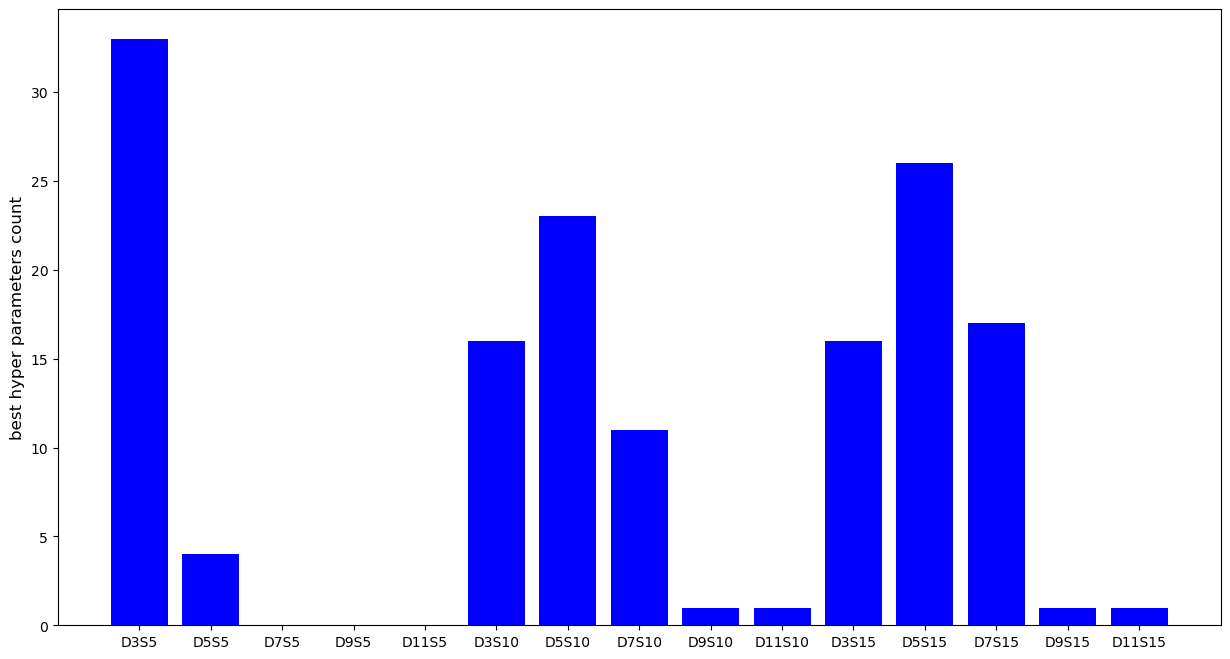

In [56]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

From the cross validation above, we can see that __max_depth = 3__ and __min_samples_split = 5__ give the best result.

In [57]:
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 5)

cv_error_array = cross_val_score(tree_reg, features, target, scoring='neg_mean_squared_error') * (-1)

average = np.average(cv_error_array)

print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this classifier is 79.40


In [58]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.07298


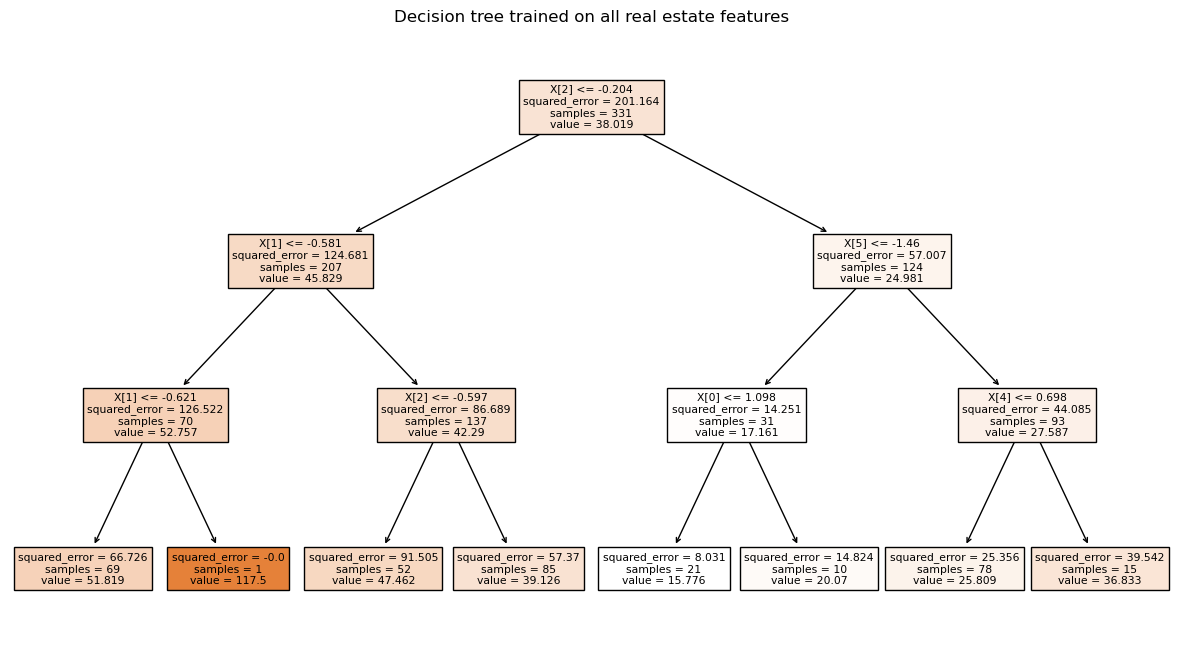

In [59]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_reg.fit(x_train, y_train), filled=True)
plt.title("Decision tree trained on all real estate features")
plt.show()

### 5. ANN

In [60]:
from tensorflow import keras
import os

model = keras.models.Sequential()  
model.add(keras.layers.Dense(units = 8, activation='relu', input_shape=(x_train.shape[1],)))
    
model.add(keras.layers.Dense(units = 1, activation='linear'))  
    
print(model.summary())  
    
model.compile(loss='mse',optimizer='sgd',  metrics=[keras.metrics.MeanSquaredError()])  

kf = KFold(n_splits=5)
k=1
    
all_score = []

for train_index, test_index in kf.split(features):
    print("fold",k)
    # Split the data
    X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
    y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        
    # training and validation
    model.fit(np.array(X_train), np.array(y_train), epochs=200, batch_size=200, verbose=2, validation_data=(np.array(X_test), np.array(y_test)))
    
    model.save(os.path.join('fold_{}_regression.hdf5'.format(k)))
    
    # evaluate the accuracy of each fold
    scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
    
    print("%s: %.2f" % (model.metrics_names[1], scores[1]))
    k = k+1
    all_score.append(scores[1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
fold 1
Train on 331 samples, validate on 83 samples
Epoch 1/200
331/331 - 0s - loss: 1598.9398 - mean_squared_error: 1598.9398 - val_loss: 926.3105 - val_mean_squared_error: 926.3105
Epoch 2/200
331/331 - 0s - loss: 950.8351 - mean_squared_error: 950.8351 - val_loss: 151.3710 - val_mean_squared_error: 151.3710
Epoch 3/200
331/331 - 0s - loss: 191.5406 - mean_squared_error: 191.5406 - val_loss: 65.5923 - val_mean_squared_error: 65.5923
Epoch 4/200
331/331 - 0s - loss: 92.0028 - mean_squared_error: 92.0027 - val

Epoch 61/200
331/331 - 0s - loss: 57.7604 - mean_squared_error: 57.7604 - val_loss: 61.0697 - val_mean_squared_error: 61.0697
Epoch 62/200
331/331 - 0s - loss: 57.2822 - mean_squared_error: 57.2822 - val_loss: 58.0767 - val_mean_squared_error: 58.0767
Epoch 63/200
331/331 - 0s - loss: 56.5188 - mean_squared_error: 56.5188 - val_loss: 60.6859 - val_mean_squared_error: 60.6859
Epoch 64/200
331/331 - 0s - loss: 58.1062 - mean_squared_error: 58.1062 - val_loss: 63.3923 - val_mean_squared_error: 63.3923
Epoch 65/200
331/331 - 0s - loss: 58.6557 - mean_squared_error: 58.6556 - val_loss: 63.3958 - val_mean_squared_error: 63.3958
Epoch 66/200
331/331 - 0s - loss: 57.9523 - mean_squared_error: 57.9523 - val_loss: 58.8856 - val_mean_squared_error: 58.8856
Epoch 67/200
331/331 - 0s - loss: 56.9743 - mean_squared_error: 56.9743 - val_loss: 56.4629 - val_mean_squared_error: 56.4629
Epoch 68/200
331/331 - 0s - loss: 57.0341 - mean_squared_error: 57.0341 - val_loss: 54.1207 - val_mean_squared_error: 

Epoch 126/200
331/331 - 0s - loss: 54.6544 - mean_squared_error: 54.6544 - val_loss: 53.3228 - val_mean_squared_error: 53.3228
Epoch 127/200
331/331 - 0s - loss: 55.8050 - mean_squared_error: 55.8050 - val_loss: 55.5684 - val_mean_squared_error: 55.5684
Epoch 128/200
331/331 - 0s - loss: 55.8225 - mean_squared_error: 55.8225 - val_loss: 59.8079 - val_mean_squared_error: 59.8079
Epoch 129/200
331/331 - 0s - loss: 54.8482 - mean_squared_error: 54.8482 - val_loss: 57.5429 - val_mean_squared_error: 57.5429
Epoch 130/200
331/331 - 0s - loss: 55.1694 - mean_squared_error: 55.1694 - val_loss: 60.9181 - val_mean_squared_error: 60.9181
Epoch 131/200
331/331 - 0s - loss: 60.0590 - mean_squared_error: 60.0590 - val_loss: 72.6813 - val_mean_squared_error: 72.6813
Epoch 132/200
331/331 - 0s - loss: 64.8907 - mean_squared_error: 64.8907 - val_loss: 66.7946 - val_mean_squared_error: 66.7946
Epoch 133/200
331/331 - 0s - loss: 58.0058 - mean_squared_error: 58.0058 - val_loss: 56.9948 - val_mean_squared

Epoch 191/200
331/331 - 0s - loss: 55.3337 - mean_squared_error: 55.3337 - val_loss: 56.7961 - val_mean_squared_error: 56.7961
Epoch 192/200
331/331 - 0s - loss: 53.8001 - mean_squared_error: 53.8001 - val_loss: 54.8414 - val_mean_squared_error: 54.8414
Epoch 193/200
331/331 - 0s - loss: 54.0678 - mean_squared_error: 54.0678 - val_loss: 61.1598 - val_mean_squared_error: 61.1598
Epoch 194/200
331/331 - 0s - loss: 54.6925 - mean_squared_error: 54.6925 - val_loss: 57.2391 - val_mean_squared_error: 57.2391
Epoch 195/200
331/331 - 0s - loss: 54.2001 - mean_squared_error: 54.2001 - val_loss: 57.5784 - val_mean_squared_error: 57.5784
Epoch 196/200
331/331 - 0s - loss: 54.6726 - mean_squared_error: 54.6726 - val_loss: 55.9494 - val_mean_squared_error: 55.9494
Epoch 197/200
331/331 - 0s - loss: 53.5203 - mean_squared_error: 53.5203 - val_loss: 53.6582 - val_mean_squared_error: 53.6582
Epoch 198/200
331/331 - 0s - loss: 53.5650 - mean_squared_error: 53.5650 - val_loss: 53.4954 - val_mean_squared

Epoch 56/200
331/331 - 0s - loss: 43.7492 - mean_squared_error: 43.7492 - val_loss: 98.8967 - val_mean_squared_error: 98.8967
Epoch 57/200
331/331 - 0s - loss: 43.0984 - mean_squared_error: 43.0984 - val_loss: 96.5853 - val_mean_squared_error: 96.5853
Epoch 58/200
331/331 - 0s - loss: 42.9604 - mean_squared_error: 42.9604 - val_loss: 105.3087 - val_mean_squared_error: 105.3087
Epoch 59/200
331/331 - 0s - loss: 49.1491 - mean_squared_error: 49.1491 - val_loss: 104.8326 - val_mean_squared_error: 104.8326
Epoch 60/200
331/331 - 0s - loss: 44.8500 - mean_squared_error: 44.8500 - val_loss: 96.9387 - val_mean_squared_error: 96.9387
Epoch 61/200
331/331 - 0s - loss: 41.8910 - mean_squared_error: 41.8910 - val_loss: 97.0133 - val_mean_squared_error: 97.0133
Epoch 62/200
331/331 - 0s - loss: 46.6793 - mean_squared_error: 46.6793 - val_loss: 106.7076 - val_mean_squared_error: 106.7076
Epoch 63/200
331/331 - 0s - loss: 49.4863 - mean_squared_error: 49.4863 - val_loss: 97.2384 - val_mean_squared_e

Epoch 121/200
331/331 - 0s - loss: 41.9212 - mean_squared_error: 41.9212 - val_loss: 96.5001 - val_mean_squared_error: 96.5001
Epoch 122/200
331/331 - 0s - loss: 42.8465 - mean_squared_error: 42.8465 - val_loss: 100.1357 - val_mean_squared_error: 100.1357
Epoch 123/200
331/331 - 0s - loss: 41.6868 - mean_squared_error: 41.6868 - val_loss: 100.5762 - val_mean_squared_error: 100.5762
Epoch 124/200
331/331 - 0s - loss: 42.4238 - mean_squared_error: 42.4238 - val_loss: 100.5737 - val_mean_squared_error: 100.5737
Epoch 125/200
331/331 - 0s - loss: 41.8540 - mean_squared_error: 41.8540 - val_loss: 98.5244 - val_mean_squared_error: 98.5244
Epoch 126/200
331/331 - 0s - loss: 42.0554 - mean_squared_error: 42.0554 - val_loss: 98.7449 - val_mean_squared_error: 98.7449
Epoch 127/200
331/331 - 0s - loss: 41.5326 - mean_squared_error: 41.5326 - val_loss: 100.6552 - val_mean_squared_error: 100.6552
Epoch 128/200
331/331 - 0s - loss: 41.2290 - mean_squared_error: 41.2290 - val_loss: 97.7595 - val_mean

Epoch 186/200
331/331 - 0s - loss: 41.2791 - mean_squared_error: 41.2791 - val_loss: 99.4341 - val_mean_squared_error: 99.4341
Epoch 187/200
331/331 - 0s - loss: 40.8772 - mean_squared_error: 40.8772 - val_loss: 99.4692 - val_mean_squared_error: 99.4692
Epoch 188/200
331/331 - 0s - loss: 40.7790 - mean_squared_error: 40.7790 - val_loss: 97.9653 - val_mean_squared_error: 97.9653
Epoch 189/200
331/331 - 0s - loss: 40.7886 - mean_squared_error: 40.7886 - val_loss: 98.9221 - val_mean_squared_error: 98.9221
Epoch 190/200
331/331 - 0s - loss: 41.5129 - mean_squared_error: 41.5129 - val_loss: 95.0850 - val_mean_squared_error: 95.0850
Epoch 191/200
331/331 - 0s - loss: 41.5867 - mean_squared_error: 41.5867 - val_loss: 99.4241 - val_mean_squared_error: 99.4241
Epoch 192/200
331/331 - 0s - loss: 41.8865 - mean_squared_error: 41.8865 - val_loss: 99.7106 - val_mean_squared_error: 99.7106
Epoch 193/200
331/331 - 0s - loss: 40.9591 - mean_squared_error: 40.9591 - val_loss: 99.0196 - val_mean_squared

Epoch 51/200
331/331 - 0s - loss: 54.4924 - mean_squared_error: 54.4924 - val_loss: 45.5992 - val_mean_squared_error: 45.5992
Epoch 52/200
331/331 - 0s - loss: 53.8669 - mean_squared_error: 53.8669 - val_loss: 45.8887 - val_mean_squared_error: 45.8887
Epoch 53/200
331/331 - 0s - loss: 54.0295 - mean_squared_error: 54.0295 - val_loss: 46.4212 - val_mean_squared_error: 46.4212
Epoch 54/200
331/331 - 0s - loss: 53.7562 - mean_squared_error: 53.7562 - val_loss: 46.0678 - val_mean_squared_error: 46.0678
Epoch 55/200
331/331 - 0s - loss: 53.5321 - mean_squared_error: 53.5321 - val_loss: 46.0679 - val_mean_squared_error: 46.0679
Epoch 56/200
331/331 - 0s - loss: 54.0423 - mean_squared_error: 54.0423 - val_loss: 49.8900 - val_mean_squared_error: 49.8900
Epoch 57/200
331/331 - 0s - loss: 55.3754 - mean_squared_error: 55.3754 - val_loss: 46.7778 - val_mean_squared_error: 46.7778
Epoch 58/200
331/331 - 0s - loss: 54.6333 - mean_squared_error: 54.6333 - val_loss: 45.8749 - val_mean_squared_error: 

Epoch 116/200
331/331 - 0s - loss: 54.1859 - mean_squared_error: 54.1859 - val_loss: 51.1603 - val_mean_squared_error: 51.1603
Epoch 117/200
331/331 - 0s - loss: 56.8813 - mean_squared_error: 56.8813 - val_loss: 48.3593 - val_mean_squared_error: 48.3593
Epoch 118/200
331/331 - 0s - loss: 57.1845 - mean_squared_error: 57.1845 - val_loss: 52.6507 - val_mean_squared_error: 52.6507
Epoch 119/200
331/331 - 0s - loss: 56.2417 - mean_squared_error: 56.2418 - val_loss: 47.3349 - val_mean_squared_error: 47.3349
Epoch 120/200
331/331 - 0s - loss: 54.2330 - mean_squared_error: 54.2330 - val_loss: 48.0119 - val_mean_squared_error: 48.0119
Epoch 121/200
331/331 - 0s - loss: 54.3264 - mean_squared_error: 54.3265 - val_loss: 48.7168 - val_mean_squared_error: 48.7168
Epoch 122/200
331/331 - 0s - loss: 54.4222 - mean_squared_error: 54.4222 - val_loss: 48.6108 - val_mean_squared_error: 48.6108
Epoch 123/200
331/331 - 0s - loss: 54.6788 - mean_squared_error: 54.6788 - val_loss: 49.2977 - val_mean_squared

Epoch 181/200
331/331 - 0s - loss: 53.6961 - mean_squared_error: 53.6961 - val_loss: 44.3936 - val_mean_squared_error: 44.3936
Epoch 182/200
331/331 - 0s - loss: 54.5811 - mean_squared_error: 54.5811 - val_loss: 47.2114 - val_mean_squared_error: 47.2114
Epoch 183/200
331/331 - 0s - loss: 56.5211 - mean_squared_error: 56.5211 - val_loss: 47.5096 - val_mean_squared_error: 47.5096
Epoch 184/200
331/331 - 0s - loss: 55.4088 - mean_squared_error: 55.4088 - val_loss: 46.8760 - val_mean_squared_error: 46.8760
Epoch 185/200
331/331 - 0s - loss: 54.3364 - mean_squared_error: 54.3364 - val_loss: 45.8113 - val_mean_squared_error: 45.8113
Epoch 186/200
331/331 - 0s - loss: 53.1098 - mean_squared_error: 53.1098 - val_loss: 44.9034 - val_mean_squared_error: 44.9034
Epoch 187/200
331/331 - 0s - loss: 52.8203 - mean_squared_error: 52.8203 - val_loss: 45.3762 - val_mean_squared_error: 45.3762
Epoch 188/200
331/331 - 0s - loss: 53.8984 - mean_squared_error: 53.8984 - val_loss: 46.4194 - val_mean_squared

Epoch 46/200
331/331 - 0s - loss: 55.0065 - mean_squared_error: 55.0065 - val_loss: 51.1182 - val_mean_squared_error: 51.1182
Epoch 47/200
331/331 - 0s - loss: 52.0560 - mean_squared_error: 52.0560 - val_loss: 54.3953 - val_mean_squared_error: 54.3953
Epoch 48/200
331/331 - 0s - loss: 52.7380 - mean_squared_error: 52.7380 - val_loss: 53.7353 - val_mean_squared_error: 53.7353
Epoch 49/200
331/331 - 0s - loss: 53.0456 - mean_squared_error: 53.0456 - val_loss: 54.8848 - val_mean_squared_error: 54.8848
Epoch 50/200
331/331 - 0s - loss: 51.4969 - mean_squared_error: 51.4969 - val_loss: 50.6584 - val_mean_squared_error: 50.6584
Epoch 51/200
331/331 - 0s - loss: 51.8164 - mean_squared_error: 51.8164 - val_loss: 52.7034 - val_mean_squared_error: 52.7034
Epoch 52/200
331/331 - 0s - loss: 51.1177 - mean_squared_error: 51.1177 - val_loss: 52.0922 - val_mean_squared_error: 52.0922
Epoch 53/200
331/331 - 0s - loss: 51.1808 - mean_squared_error: 51.1808 - val_loss: 51.5881 - val_mean_squared_error: 

Epoch 111/200
331/331 - 0s - loss: 50.8842 - mean_squared_error: 50.8842 - val_loss: 56.2253 - val_mean_squared_error: 56.2253
Epoch 112/200
331/331 - 0s - loss: 51.1565 - mean_squared_error: 51.1565 - val_loss: 53.9468 - val_mean_squared_error: 53.9468
Epoch 113/200
331/331 - 0s - loss: 50.6038 - mean_squared_error: 50.6038 - val_loss: 57.3921 - val_mean_squared_error: 57.3921
Epoch 114/200
331/331 - 0s - loss: 51.0556 - mean_squared_error: 51.0556 - val_loss: 53.2513 - val_mean_squared_error: 53.2513
Epoch 115/200
331/331 - 0s - loss: 54.6426 - mean_squared_error: 54.6426 - val_loss: 52.3665 - val_mean_squared_error: 52.3665
Epoch 116/200
331/331 - 0s - loss: 50.3597 - mean_squared_error: 50.3597 - val_loss: 58.6725 - val_mean_squared_error: 58.6725
Epoch 117/200
331/331 - 0s - loss: 51.3227 - mean_squared_error: 51.3227 - val_loss: 52.7019 - val_mean_squared_error: 52.7019
Epoch 118/200
331/331 - 0s - loss: 50.0448 - mean_squared_error: 50.0448 - val_loss: 56.3565 - val_mean_squared

Epoch 176/200
331/331 - 0s - loss: 51.5075 - mean_squared_error: 51.5075 - val_loss: 57.6243 - val_mean_squared_error: 57.6243
Epoch 177/200
331/331 - 0s - loss: 49.9467 - mean_squared_error: 49.9467 - val_loss: 59.0748 - val_mean_squared_error: 59.0748
Epoch 178/200
331/331 - 0s - loss: 49.2811 - mean_squared_error: 49.2811 - val_loss: 58.8644 - val_mean_squared_error: 58.8644
Epoch 179/200
331/331 - 0s - loss: 50.3714 - mean_squared_error: 50.3714 - val_loss: 59.7298 - val_mean_squared_error: 59.7298
Epoch 180/200
331/331 - 0s - loss: 54.2203 - mean_squared_error: 54.2203 - val_loss: 58.5059 - val_mean_squared_error: 58.5059
Epoch 181/200
331/331 - 0s - loss: 53.5570 - mean_squared_error: 53.5570 - val_loss: 56.5182 - val_mean_squared_error: 56.5182
Epoch 182/200
331/331 - 0s - loss: 49.3446 - mean_squared_error: 49.3446 - val_loss: 59.5785 - val_mean_squared_error: 59.5785
Epoch 183/200
331/331 - 0s - loss: 49.1285 - mean_squared_error: 49.1285 - val_loss: 59.4911 - val_mean_squared

Epoch 41/200
332/332 - 0s - loss: 55.4963 - mean_squared_error: 55.4963 - val_loss: 48.7622 - val_mean_squared_error: 48.7622
Epoch 42/200
332/332 - 0s - loss: 51.9738 - mean_squared_error: 51.9738 - val_loss: 49.7352 - val_mean_squared_error: 49.7352
Epoch 43/200
332/332 - 0s - loss: 51.2732 - mean_squared_error: 51.2732 - val_loss: 46.6534 - val_mean_squared_error: 46.6534
Epoch 44/200
332/332 - 0s - loss: 52.2946 - mean_squared_error: 52.2946 - val_loss: 44.4012 - val_mean_squared_error: 44.4012
Epoch 45/200
332/332 - 0s - loss: 51.4696 - mean_squared_error: 51.4696 - val_loss: 45.2465 - val_mean_squared_error: 45.2465
Epoch 46/200
332/332 - 0s - loss: 52.3085 - mean_squared_error: 52.3085 - val_loss: 44.3820 - val_mean_squared_error: 44.3820
Epoch 47/200
332/332 - 0s - loss: 52.8699 - mean_squared_error: 52.8699 - val_loss: 45.7207 - val_mean_squared_error: 45.7207
Epoch 48/200
332/332 - 0s - loss: 52.0491 - mean_squared_error: 52.0491 - val_loss: 45.5858 - val_mean_squared_error: 

Epoch 106/200
332/332 - 0s - loss: 51.5797 - mean_squared_error: 51.5797 - val_loss: 49.5674 - val_mean_squared_error: 49.5674
Epoch 107/200
332/332 - 0s - loss: 53.1086 - mean_squared_error: 53.1086 - val_loss: 46.0407 - val_mean_squared_error: 46.0407
Epoch 108/200
332/332 - 0s - loss: 51.9266 - mean_squared_error: 51.9266 - val_loss: 50.9462 - val_mean_squared_error: 50.9462
Epoch 109/200
332/332 - 0s - loss: 54.0385 - mean_squared_error: 54.0385 - val_loss: 49.9329 - val_mean_squared_error: 49.9329
Epoch 110/200
332/332 - 0s - loss: 53.7715 - mean_squared_error: 53.7715 - val_loss: 48.7638 - val_mean_squared_error: 48.7638
Epoch 111/200
332/332 - 0s - loss: 53.1995 - mean_squared_error: 53.1995 - val_loss: 47.3736 - val_mean_squared_error: 47.3736
Epoch 112/200
332/332 - 0s - loss: 52.6753 - mean_squared_error: 52.6753 - val_loss: 48.6145 - val_mean_squared_error: 48.6145
Epoch 113/200
332/332 - 0s - loss: 51.9574 - mean_squared_error: 51.9574 - val_loss: 46.4667 - val_mean_squared

Epoch 171/200
332/332 - 0s - loss: 51.6133 - mean_squared_error: 51.6133 - val_loss: 45.3293 - val_mean_squared_error: 45.3293
Epoch 172/200
332/332 - 0s - loss: 52.1374 - mean_squared_error: 52.1374 - val_loss: 46.7192 - val_mean_squared_error: 46.7192
Epoch 173/200
332/332 - 0s - loss: 50.7044 - mean_squared_error: 50.7044 - val_loss: 45.4638 - val_mean_squared_error: 45.4638
Epoch 174/200
332/332 - 0s - loss: 50.7564 - mean_squared_error: 50.7564 - val_loss: 46.3966 - val_mean_squared_error: 46.3966
Epoch 175/200
332/332 - 0s - loss: 52.3166 - mean_squared_error: 52.3166 - val_loss: 45.0839 - val_mean_squared_error: 45.0839
Epoch 176/200
332/332 - 0s - loss: 50.6774 - mean_squared_error: 50.6774 - val_loss: 44.7803 - val_mean_squared_error: 44.7803
Epoch 177/200
332/332 - 0s - loss: 50.9007 - mean_squared_error: 50.9007 - val_loss: 45.5783 - val_mean_squared_error: 45.5783
Epoch 178/200
332/332 - 0s - loss: 51.1340 - mean_squared_error: 51.1340 - val_loss: 48.2623 - val_mean_squared

In [61]:
print(all_score)

[59.13914, 101.73887, 46.890236, 59.198067, 45.634857]


In [62]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

model.load_weights('fold_2_regression.hdf5')

model.predict(np.array(x_test))

loss, mse = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)
print("Restored model best performance, MSE: {:5.2f}".format(mse))

83/83 - 0s - loss: 26.6505 - mean_squared_error: 26.6505
Restored model best performance, MSE: 26.65


In [63]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(mse)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.04228
